In [1]:
#import
import os, sys
os.chdir('/home/koritskiy/rqc/hamiltonian_learning')

import numpy as np
from sklearn.metrics import mean_squared_error as mse
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython import display

from modules.matrices import *
from modules.loss_functions import *

In [2]:
# Plot function
def double_plot(MSE, TD):
    display.clear_output(wait=True)
    X = range(len(MSE))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('iterations')
    ax1.set_ylabel(f'MSE', color=color)
    ax1.scatter(X, MSE, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(f'TD', color=color)  # we've already handled the x-label with ax1
    ax2.scatter(X, TD, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

In [3]:
# Main function
def construct(N_iterations, d_max_iter, g_max_iter):
    TD = []
    MSE = []
    params = []
    
    # initiate coefs (couplings and fields) and angles 
    h_g, J_g = generate_params(fields, interactions, N_spins)
    rho_g = density_matr(h_g, J_g, beta, model)
    angles = np.zeros((2, N_spins))
    flat_params_g = np.concatenate((h_g.flatten(), J_g.flatten()))
    MSE.append(mse(h_g, h_t) + mse(J_g, J_t))
    TD.append(g_loss_func(flat_params_g, rho_t, angles, beta, model, fields, interactions, N_spins))
    for _ in range(N_iterations):   
#         if MSE[-1] < 10 ** -5:
#             print("Great! 10^-5 MSE threshold was achieved")
#             break
        
        # Find most suitable coefs
        result_g = minimize(g_loss_func,
                        args=(rho_t, angles, beta, model, fields, interactions, N_spins),
                        x0=flat_params_g,
                        method='Nelder-Mead',
                        options={'maxiter':g_max_iter}) # to change
        flat_params_g = np.array(result_g.x)
        h_g, J_g = flat_to_params(flat_params_g, fields, interactions, N_spins)
        rho_g = density_matr(h_g, J_g, beta, model)
        params.append([h_g, J_g])
        # Keep track of errors change
        TD.append(result_g.fun)
        MSE.append(mse(h_g, h_t) + mse(J_g, J_t))
        double_plot(MSE, TD)
        # Find basis
        result_d = minimize(d_loss_func,
                        args=(rho_g, rho_t),
                        x0=angles.reshape(2*N_spins),
                        method='Nelder-Mead',
                        options={'maxiter':d_max_iter}).x
        angles = result_d.reshape(2, N_spins)

    return MSE, TD, params, angles

In [7]:
# Target hamiltonian we need to restore
beta = 0.3
N_spins = 3
ising = False
fields = 1
interactions = 2
model = 'XY'
h_t, J_t = generate_params(fields, interactions, N_spins)
rho_t = density_matr(h_t, J_t, beta, model)
rho_t

array([[ 0.04591553+0.j,  0.        +0.j,  0.        +0.j,
        -0.01585295+0.j,  0.        +0.j, -0.01850626+0.j,
         0.04570535+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.07308603+0.j, -0.05265849+0.j,
         0.        +0.j, -0.01741688+0.j,  0.        +0.j,
         0.        +0.j,  0.05754088+0.j],
       [ 0.        +0.j, -0.05265849+0.j,  0.11531503+0.j,
         0.        +0.j,  0.0481918 +0.j,  0.        +0.j,
         0.        +0.j, -0.02257858+0.j],
       [-0.01585295+0.j,  0.        +0.j,  0.        +0.j,
         0.1286344 +0.j,  0.        +0.j,  0.06312415+0.j,
        -0.02730761+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.01741688+0.j,  0.0481918 +0.j,
         0.        +0.j,  0.08210242+0.j,  0.        +0.j,
         0.        +0.j, -0.02626041+0.j],
       [-0.01850626+0.j,  0.        +0.j,  0.        +0.j,
         0.06312415+0.j,  0.        +0.j,  0.13153878+0.j,
        -0.09430084+0.j,  0.        +0.j],
       [ 0.04570535+0.j,  0.      

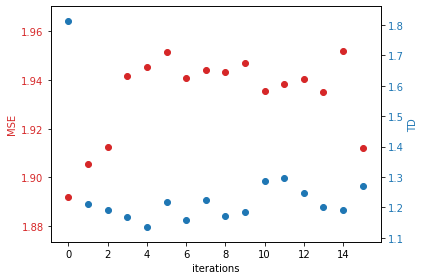

In [8]:
# Run
np.random.seed(41)
N_iterations = 15
MSE, TD, params, angles = construct(N_iterations,
                                    d_max_iter=1000,
                                    g_max_iter=1000)


In [12]:
MSE

[2.1354356867970887,
 0.4356359414604332,
 0.14647822154719262,
 0.019051694407942795,
 0.03199982769613307,
 0.00533859322181844,
 0.0013271651579381777,
 0.0006032310969168134,
 0.00017773367542926676,
 0.0006725437869989374,
 8.593725689055264e-05,
 0.00025082638552642887,
 0.0009464910670481481,
 0.0007050849816279824,
 0.010491323072436397,
 0.0007617918652898587]

In [13]:
TD

[0.19247040569161206,
 5.946616648128122e-06,
 8.773551644941646e-06,
 2.593758492153153e-07,
 2.215159800506017e-06,
 1.252125433948148e-06,
 3.60451870545786e-07,
 8.217102287766398e-07,
 2.561247291199553e-07,
 3.9812671101535635e-07,
 1.9610657805979592e-07,
 1.2180679043183318e-07,
 3.811983574353306e-07,
 7.080535397718801e-07,
 1.6956713194682393e-07,
 4.441120049492042e-08]

In [14]:
print(h_t)
print(J_t)

[[ 0.17811184 -0.52278352]]
[[0.54905059]
 [0.96857695]]


In [16]:
print(params[-2][0])
print(params[-2][1])

[[ 0.17910872 -0.52584277]]
[[0.48666012]
 [1.09926637]]


In [ ]:
density_matr(params_t, beta, ising)

In [ ]:
density_matr(params[-1], beta, ising)

In [ ]:
d_max_iters = [i for i in range(100, 2000, 100)]

In [ ]:
MSEs = []
TDs = []
paramss = []
for d_iter in d_max_iters:
    np.random.seed(43)
    N_iterations = 20
    MSE, TD, params, angles = construct(N_iterations,
                                    d_max_iter=d_iter,
                                    g_max_iter=2000-d_iter,
                                    beta = 0.3,
                                    ising=ising)
    MSEs.append(MSE)
    TDs.append(TD)
    paramss.appdend(params)
    double_plot(MSE, TD)

In [8]:
import numpy as np
np.zeros((0, 0))
    

array([], shape=(0, 0), dtype=float64)